# Covid19 in Bayern
In dem Projekt werden die Corona-Daten des RKI analysiert. Dabei werden die Elementaren Schritte der Datenanalyse durchgeführt:
- Einlesen der Daten
- Prüfen der Datenqualität
- Beseitung von Datenqualitätsproblemen
- Visuelle Analyse und Ableitung von Zusammenhängen der Daten


## Einlesen der Daten
Analyse der *RKI*-Daten für einen entsprechenden Einblick über den Verlauf der Pandemie
Zusätliches Dataframe mittels *Webscraping von Wikipedia* um die Bevölkerungszahlen für die Deutschen Bundesländer zu erhalten

In [1]:
# Import der benötigten Features
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
plt.style.use('ggplot')
#seaborn.set()

url = "https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data"
df = pd.read_csv(url , parse_dates = ['Meldedatum', 'Refdatum'])

#df = pd.read_csv('RKI_COVID19.csv' , parse_dates = ['Meldedatum', 'Refdatum'])

list_category = ['FID', 'IdBundesland', 'Bundesland', 'Landkreis', 'Altersgruppe', 'Geschlecht', 
                'IdLandkreis', 'Datenstand']
list_int = ['AnzahlFall', 'Anzahl_Todesfall', 'NeuerFall', 'NeuerTodesfall']

for i in list_category:
    df.loc[:, i] = df.loc[:, i].astype('category')
    
#Konstanten
ew_by100000 = 13076721 / 100000


# Einlesen der Bevölkerungsdaten der Bundesländer mittels Webscraping auf Wikipedia
url = 'https://de.wikipedia.org/wiki/Liste_der_deutschen_Bundesl%C3%A4nder_nach_Bev%C3%B6lkerung'
df_ewbl = pd.read_html(url, thousands='.', decimal=',') 

# Anpassen der Daten um diese leichter verarbeiten zu können
df_ewbl = df_ewbl[0].loc[:, [('Bundesland / Jahr', 'Bundesland / Jahr'), (        'Einwohner',              '2020')]]
df_ewbl.columns = ['Bundesland', '2020'] # Benennung der Spalten
df_ewbl.replace({'Bundesland': {'Berlin[1]': 'Berlin', 'Deutschland[2]': 'Deutschland'}}, inplace= True)
df_ewbl.set_index('Bundesland', inplace = True) # Neuer Index

# Überblick über die DataFrames
print(df.head())
print(df_ewbl.head())

  FID IdBundesland          Bundesland     Landkreis Altersgruppe Geschlecht  \
0   1            1  Schleswig-Holstein  SK Flensburg      A15-A34          M   
1   2            1  Schleswig-Holstein  SK Flensburg      A15-A34          M   
2   3            1  Schleswig-Holstein  SK Flensburg      A15-A34          M   
3   4            1  Schleswig-Holstein  SK Flensburg      A15-A34          M   
4   5            1  Schleswig-Holstein  SK Flensburg      A15-A34          M   

   AnzahlFall  AnzahlTodesfall Meldedatum IdLandkreis             Datenstand  \
0           1                0 2021-04-08        1001  03.01.2022, 00:00 Uhr   
1           1                0 2021-04-08        1001  03.01.2022, 00:00 Uhr   
2           1                0 2021-04-09        1001  03.01.2022, 00:00 Uhr   
3           2                0 2021-04-10        1001  03.01.2022, 00:00 Uhr   
4           1                0 2021-04-13        1001  03.01.2022, 00:00 Uhr   

   NeuerFall  NeuerTodesfall   Refdatu

Diese Funktion reichert die Daten um einige benötigte bzw. gern genutzte Kennzahlen an. Dafür ist es notwendig, dass ein DataFrame aggregiert nach dem Meldedatum sowie die Einwohnerzahl der betrachteten Region mitgegeben wird.

In [2]:
#calculate 7day average invections / deaths as well as 7-day incidenz
def sevendayavg(df, ew_100000):
    for i in range(1, 7):
        df.loc[:, 'AnzahlFall-{}'.format(i)] = df.loc[:, 'AnzahlFall'].shift(i)
        df.loc[:, 'AnzahlTodesfall-{}'.format(i)] = df.loc[:, 'AnzahlTodesfall'].shift(i)

    df.loc[:, 'AVG_AnzahlFall'] = (df.loc[:, 'AnzahlFall'] +
                                   df.loc[:, 'AnzahlFall-1'] +
                                   df.loc[:, 'AnzahlFall-2'] +
                                   df.loc[:, 'AnzahlFall-3'] +
                                   df.loc[:, 'AnzahlFall-4'] +
                                   df.loc[:, 'AnzahlFall-5'] +
                                   df.loc[:, 'AnzahlFall-6'] ) / 7
    df.loc[:, 'AVG_AnzahlTodesfall'] = (df.loc[:, 'AnzahlTodesfall'] +
                                   df.loc[:, 'AnzahlTodesfall-1'] +
                                   df.loc[:, 'AnzahlTodesfall-2'] +
                                   df.loc[:, 'AnzahlTodesfall-3'] +
                                   df.loc[:, 'AnzahlTodesfall-4'] +
                                   df.loc[:, 'AnzahlTodesfall-5'] +
                                   df.loc[:, 'AnzahlTodesfall-6'] ) / 7
    df.loc[:, '7day_inzidenz'] = (df.loc[:, 'AnzahlFall'] +
                                   df.loc[:, 'AnzahlFall-1'] +
                                   df.loc[:, 'AnzahlFall-2'] +
                                   df.loc[:, 'AnzahlFall-3'] +
                                   df.loc[:, 'AnzahlFall-4'] +
                                   df.loc[:, 'AnzahlFall-5'] +
                                   df.loc[:, 'AnzahlFall-6'] ) / ew_100000
    return df.loc[:, ['AnzahlFall', 'AVG_AnzahlFall', 'AnzahlTodesfall', 'AVG_AnzahlTodesfall', '7day_inzidenz']]

## Data Quality checks
Bevor die Analyse startet werden die Grundlegenden Eigenschaften des Imports überprüft um sicherzustellen, dass die Import korrekt war

In [3]:
# Überprüfung der Dateneigenschaften

print('Eigenschaften der Datentypen: \n {} \n'.format(df.dtypes))
print('Fehlende Werte: \n {}'.format(df.isnull().sum()))
print('\nUmfang Datensatz: {:,}'.format(df.shape[0]))

Eigenschaften der Datentypen: 
 FID                           category
IdBundesland                  category
Bundesland                    category
Landkreis                     category
Altersgruppe                  category
Geschlecht                    category
AnzahlFall                       int64
AnzahlTodesfall                  int64
Meldedatum              datetime64[ns]
IdLandkreis                   category
Datenstand                    category
NeuerFall                        int64
NeuerTodesfall                   int64
Refdatum                datetime64[ns]
NeuGenesen                       int64
AnzahlGenesen                    int64
IstErkrankungsbeginn             int64
Altersgruppe2                   object
dtype: object 

Fehlende Werte: 
 FID                     0
IdBundesland            0
Bundesland              0
Landkreis               0
Altersgruppe            0
Geschlecht              0
AnzahlFall              0
AnzahlTodesfall         0
Meldedatum              

## Erster Blick auf die Daten
Zu Beginn soll ein Verständniss für die Daten gewonnen werden um erste Erkenntnisse zu bekommen, welche weitere Auswertungen hier Sinn machen

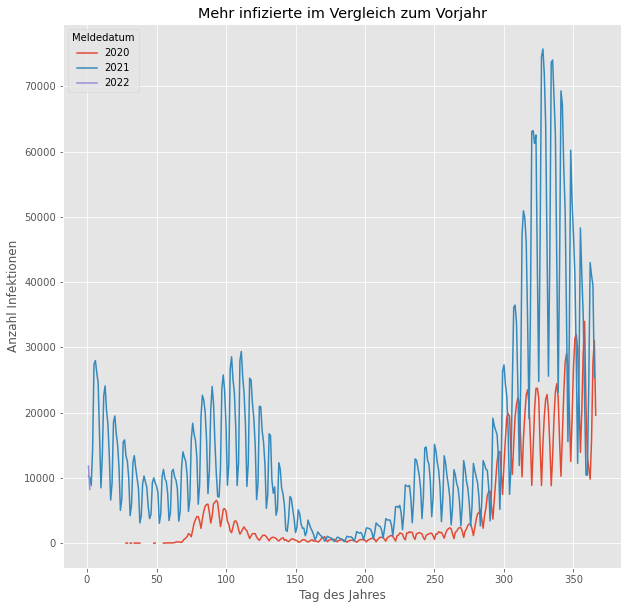

In [4]:
# first view on the time series
pd.crosstab(index = df['Meldedatum'].dt.dayofyear, columns = df['Meldedatum'].dt.year, values = df['AnzahlFall'], aggfunc = 'sum').plot(figsize = [10, 10])
plt.xlabel('Tag des Jahres')
plt.ylabel('Anzahl Infektionen')
plt.title('Mehr infizierte im Vergleich zum Vorjahr')
plt.show()

C:\Users\josef\AppData\Local\Temp/ipykernel_7296/3341107324.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  pd.crosstab(index = df['Meldedatum'].dt.week, columns = df['Meldedatum'].dt.year, values = df['AnzahlFall'], aggfunc = 'sum').plot(figsize = [10,10])


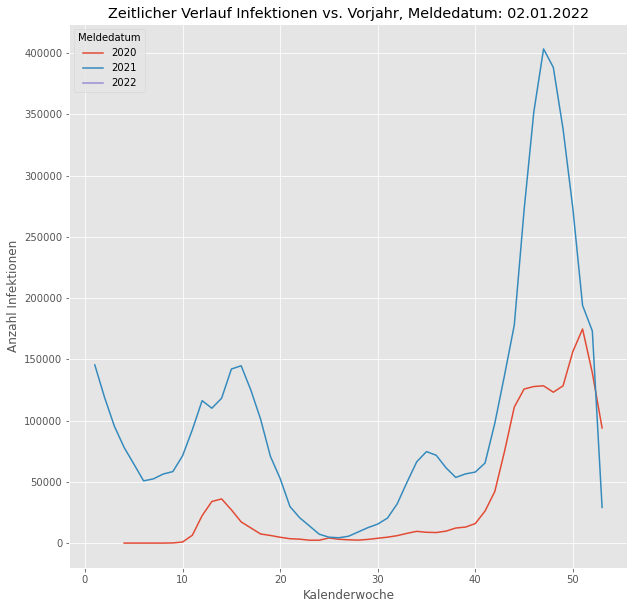

In [5]:
pd.crosstab(index = df['Meldedatum'].dt.week, columns = df['Meldedatum'].dt.year, values = df['AnzahlFall'], aggfunc = 'sum').plot(figsize = [10,10])
plt.title('Zeitlicher Verlauf Infektionen vs. Vorjahr, Meldedatum: {}'.format(df['Meldedatum'].max().strftime(format = '%d.%m.%Y')))
plt.ylabel('Anzahl Infektionen')
plt.xlabel('Kalenderwoche')
plt.savefig('Invektionen_vs_Vorjahr_{}.png'.format(df['Meldedatum'].max().strftime(format = '%d.%m.%Y')))
plt.show()

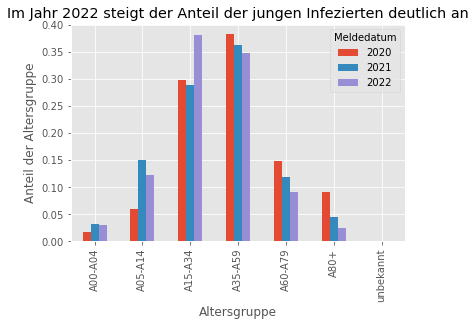

In [6]:
pd.crosstab(index = df['Altersgruppe'], columns = df['Meldedatum'].dt.year, values = df['AnzahlFall'], aggfunc = 'sum', normalize = 'columns').plot(kind = 'bar')
plt.title('Im Jahr {} steigt der Anteil der jungen Infezierten deutlich an'.format(df['Meldedatum'].dt.year.max()))
plt.ylabel('Anteil der Altersgruppe')
plt.show()

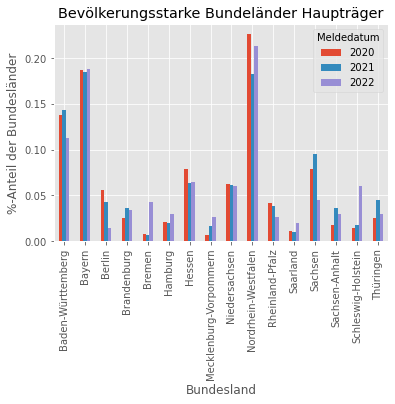

In [7]:
pd.crosstab(index = df['Bundesland'], columns = df['Meldedatum'].dt.year, values = df['AnzahlFall'], aggfunc = 'sum', normalize = 'columns').plot(kind = 'bar')
plt.title('Bevölkerungsstarke Bundeländer Haupträger')
plt.ylabel('%-Anteil der Bundesländer')
plt.show()

['Schleswig-Holstein', 'Hamburg', 'Niedersachsen', 'Bremen', 'Nordrhein-Westfalen', 'Hessen', 'Rheinland-Pfalz', 'Baden-Württemberg', 'Bayern', 'Saarland', 'Berlin', 'Brandenburg', 'Mecklenburg-Vorpommern', 'Sachsen', 'Sachsen-Anhalt', 'Thüringen']


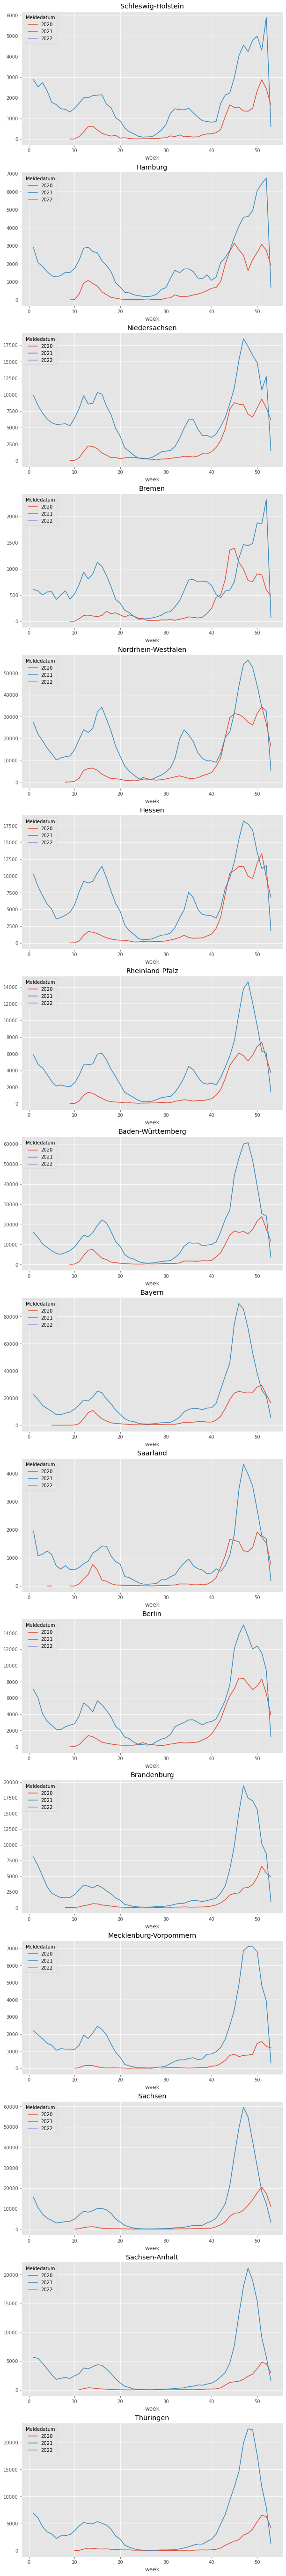

In [8]:
laender = list(df['Bundesland'].unique())
print(laender)

fig, ax = plt.subplots(nrows = len(laender), figsize = [10, 100])

for i, j in enumerate(laender):
    mask = df['Bundesland'] == j
    df_plot = df.loc[mask, :]
    pd.crosstab(index = df_plot['Meldedatum'].dt.isocalendar().week, columns = df_plot['Meldedatum'].dt.year, 
                values = df_plot['AnzahlFall'], aggfunc = 'sum').plot(ax = ax[i])

for i, j in enumerate(laender):  
    ax[i].set_title(laender[i])
 


plt.show()

# Analyse der Altersstruktur
Infektionen und Todesfälle werden nach alter Analysiert, um das Risiko für die einzelnen Schichten abzuleiten

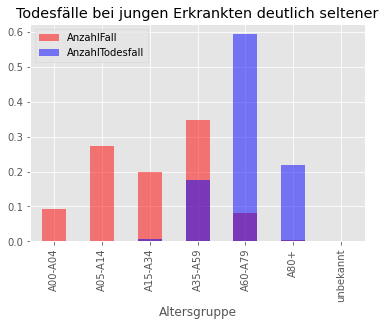

In [9]:
# Analyse für Deutschland

fig, ax = plt.subplots()
mask = df['Meldedatum'] > '2021-09-15'
df_plot = df.loc[mask, ['Altersgruppe', 'AnzahlFall']].groupby('Altersgruppe').sum()
mult = [20, 10, 5, 100/15, 5]
for i, j in enumerate(mult):
    df_plot.iloc[i, 0] = df_plot.iloc[i, 0] * j
df_plot['AnzahlFall'] = df_plot['AnzahlFall'] / df_plot['AnzahlFall'].sum()
df_plot.plot(kind = 'bar', ax = ax, color='r', alpha = 0.5)

df_plot = df.loc[mask, ['Altersgruppe', 'AnzahlTodesfall']].groupby('Altersgruppe').sum()
df_plot.head()

# Da die Altersgruppen unterschiedliche Anzahlen an Jahrgängen umfassen werden diese normalisiert um die Aussagekraft zu erhöhen
mult = [20, 10, 5, 100/15, 5]
for i, j in enumerate(mult):
    df_plot.iloc[i, 0] = df_plot.iloc[i, 0] * j
df_plot['AnzahlTodesfall'] = df_plot['AnzahlTodesfall'] / df_plot['AnzahlTodesfall'].sum()
df_plot.plot(kind = 'bar', ax = ax, color='b', alpha = 0.5)

plt.title('Todesfälle bei jungen Erkrankten deutlich seltener')
plt.show()

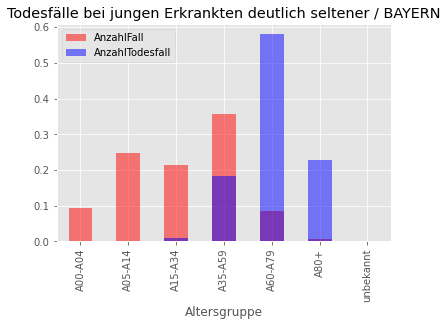

In [10]:
# Analyse für Bayern

mask = (df.loc[:, 'Meldedatum'] > '2021-09-15') & (df.loc[:, 'Bundesland'] == 'Bayern')
fig, ax = plt.subplots()
df_plot = df.loc[mask, ['Altersgruppe', 'AnzahlFall']].groupby('Altersgruppe').sum()
mult = [20, 10, 5, 100/15, 5]
for i, j in enumerate(mult):
    df_plot.iloc[i, 0] = df_plot.iloc[i, 0] * j
df_plot['AnzahlFall'] = df_plot['AnzahlFall'] / df_plot['AnzahlFall'].sum()
df_plot.plot(kind = 'bar', ax = ax, color='r', alpha = 0.5)

df_plot = df.loc[mask, ['Altersgruppe', 'AnzahlTodesfall']].groupby('Altersgruppe').sum()
df_plot.head()
mult = [20, 10, 5, 100/15, 5]
for i, j in enumerate(mult):
    df_plot.iloc[i, 0] = df_plot.iloc[i, 0] * j
df_plot['AnzahlTodesfall'] = df_plot['AnzahlTodesfall'] / df_plot['AnzahlTodesfall'].sum()
df_plot.plot(kind = 'bar', ax = ax, color='b', alpha = 0.5)

plt.title('Todesfälle bei jungen Erkrankten deutlich seltener / BAYERN')
plt.savefig('Fall_Todesfall.png')
plt.show()

Obwohl sich deutlich weniger ältere Menschen anstecken ist ihr Anteil an den Todesfällen beträchtlich

## Zeitlicher Verlauf
Illustration des zeitlichen Verlaufs für Ansteckungen und  Todesfälle

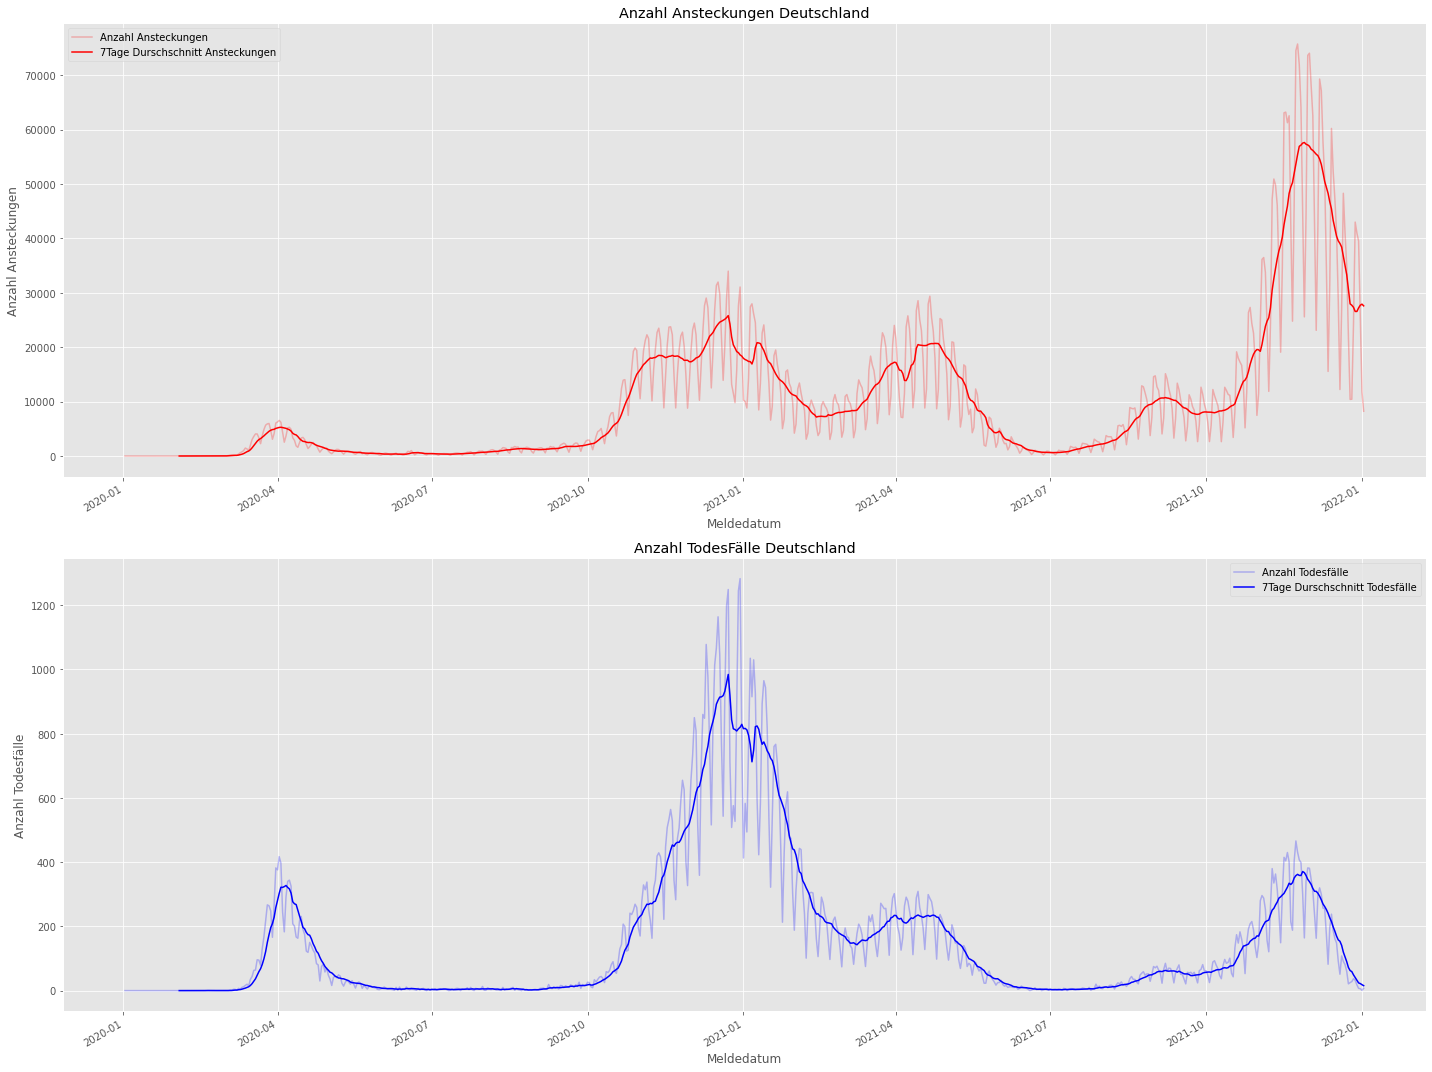

In [11]:
df_plot = sevendayavg(df.groupby('Meldedatum')[['AnzahlFall', 'AnzahlTodesfall']].sum(), ew_by100000)

# Figure mit 2 Axes für Ansteckungen u. Todesfällen
fig, ax = plt.subplots(nrows = 2, figsize = (20, 15))

# Todesfälle
df_plot.loc[:, 'AnzahlTodesfall'].plot(ax = ax[1], alpha = 0.25, c = 'b', label = 'Anzahl Todesfälle')
df_plot.loc[:, 'AVG_AnzahlTodesfall'].plot(ax = ax[1], c = 'b', label = '7Tage Durschschnitt Todesfälle')
# Ansteckungen
df_plot.loc[:, 'AnzahlFall'].plot(ax = ax[0], alpha = 0.25, c='r')
df_plot.loc[:, 'AVG_AnzahlFall'].plot(ax = ax[0], c = 'r')

# Beschrisftungen um Verständlichkeit zu erhöhen
ax[0].set_title('Anzahl Ansteckungen Deutschland')
ax[1].set_title('Anzahl TodesFälle Deutschland')
ax[0].set_ylabel('Anzahl Ansteckungen')
ax[1].set_ylabel('Anzahl Todesfälle')
ax[0].legend(['Anzahl Ansteckungen',  '7Tage Durschschnitt Ansteckungen'])
ax[1].legend(['Anzahl Todesfälle',  '7Tage Durschschnitt Todesfälle'])
plt.tight_layout()
plt.show()

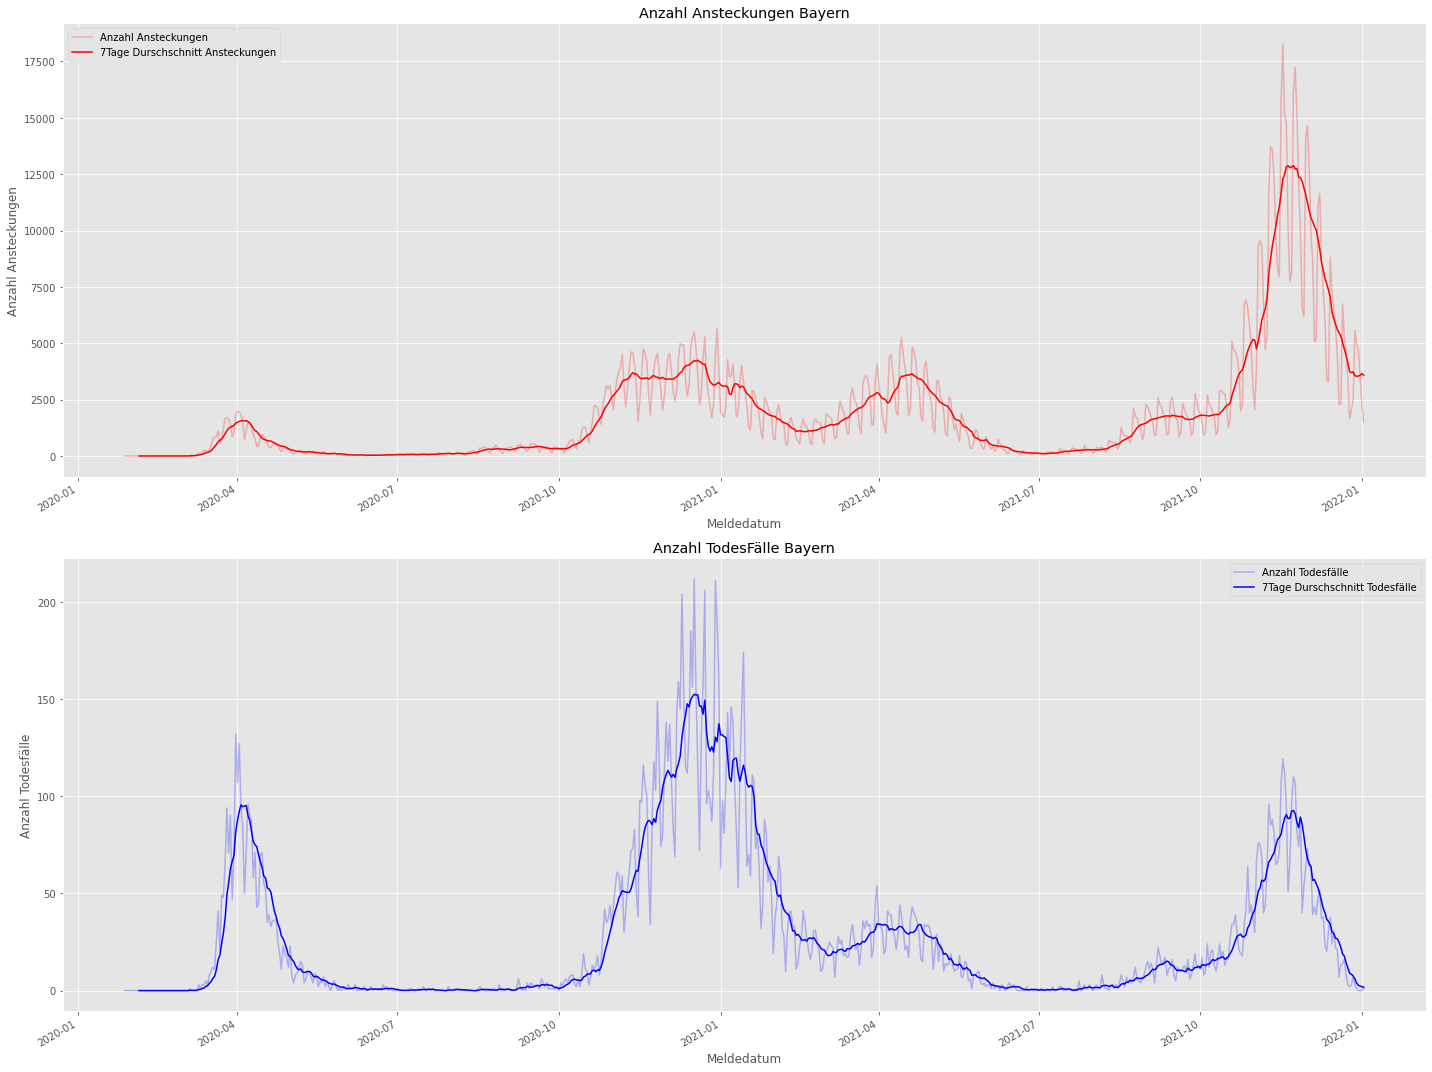

In [12]:
mask = df.loc[:, 'Bundesland'] == 'Bayern'
df_plot = sevendayavg(df.loc[mask, :].groupby('Meldedatum')[['AnzahlFall', 'AnzahlTodesfall']].sum(), ew_by100000)
fig, ax = plt.subplots(nrows = 2, figsize = (20,15))

df_plot.loc[:, 'AnzahlTodesfall'].plot(ax = ax[1], alpha = 0.25, c = 'b', label = 'Anzahl Todesfälle')
df_plot.loc[:, 'AVG_AnzahlTodesfall'].plot(ax = ax[1], c = 'b', label = '7Tage Durschschnitt Todesfälle')

df_plot.loc[:, 'AnzahlFall'].plot(ax = ax[0], alpha = 0.25, c='r')
df_plot.loc[:, 'AVG_AnzahlFall'].plot(ax = ax[0], c = 'r')


ax[0].set_title('Anzahl Ansteckungen Bayern')
ax[1].set_title('Anzahl TodesFälle Bayern')
ax[0].set_ylabel('Anzahl Ansteckungen')
ax[1].set_ylabel('Anzahl Todesfälle')
ax[0].legend(['Anzahl Ansteckungen',  '7Tage Durschschnitt Ansteckungen'])
ax[1].legend(['Anzahl Todesfälle',  '7Tage Durschschnitt Todesfälle'])
plt.tight_layout()
plt.show()

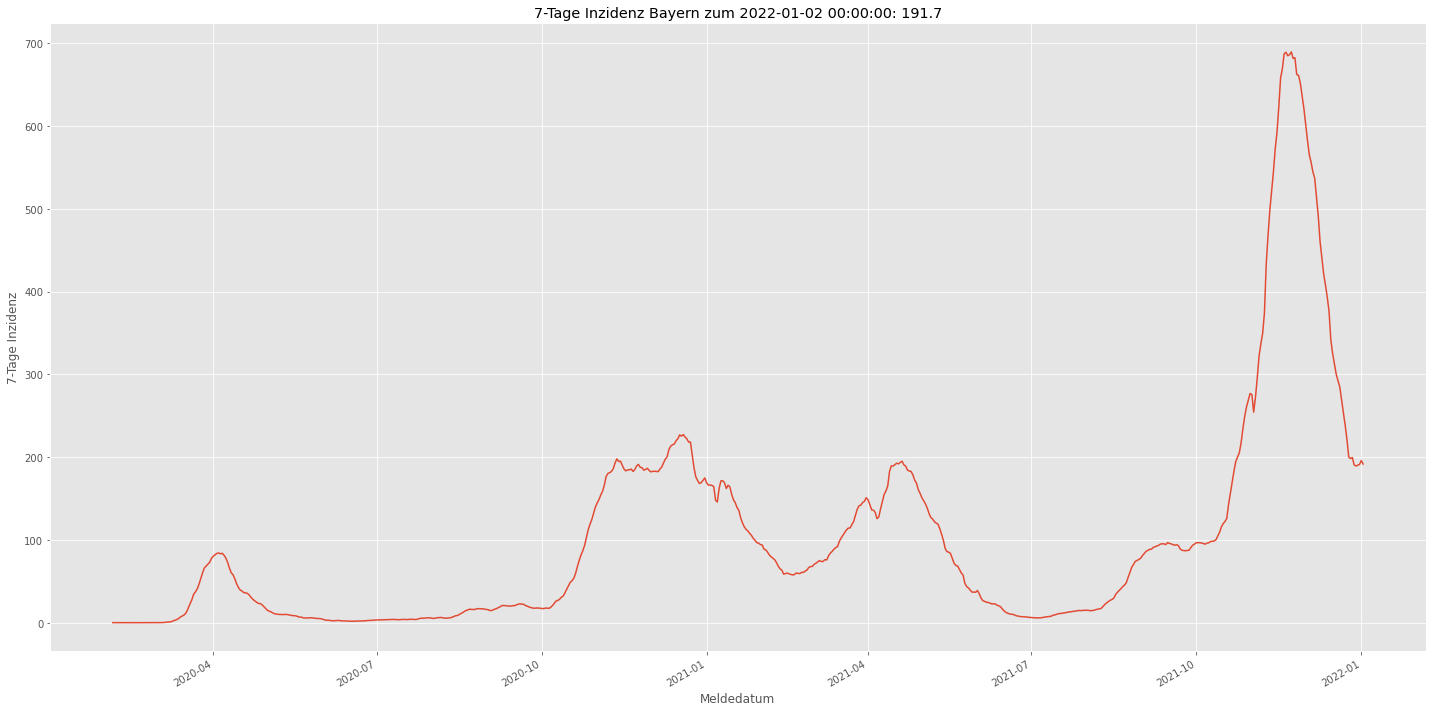

In [13]:
df_plot.loc[:, '7day_inzidenz'].plot(figsize = (20, 10))
plt.title('7-Tage Inzidenz Bayern zum {}: {:.1f}'.format(df_plot.index[-1], df_plot.iloc[-1, 4]))
plt.ylabel('7-Tage Inzidenz')
plt.tight_layout()
plt.show()

## Vergleich der unterschiedlichen Bundesländer
Auswertung und Visualisierung der Daten für alle Bundesländer

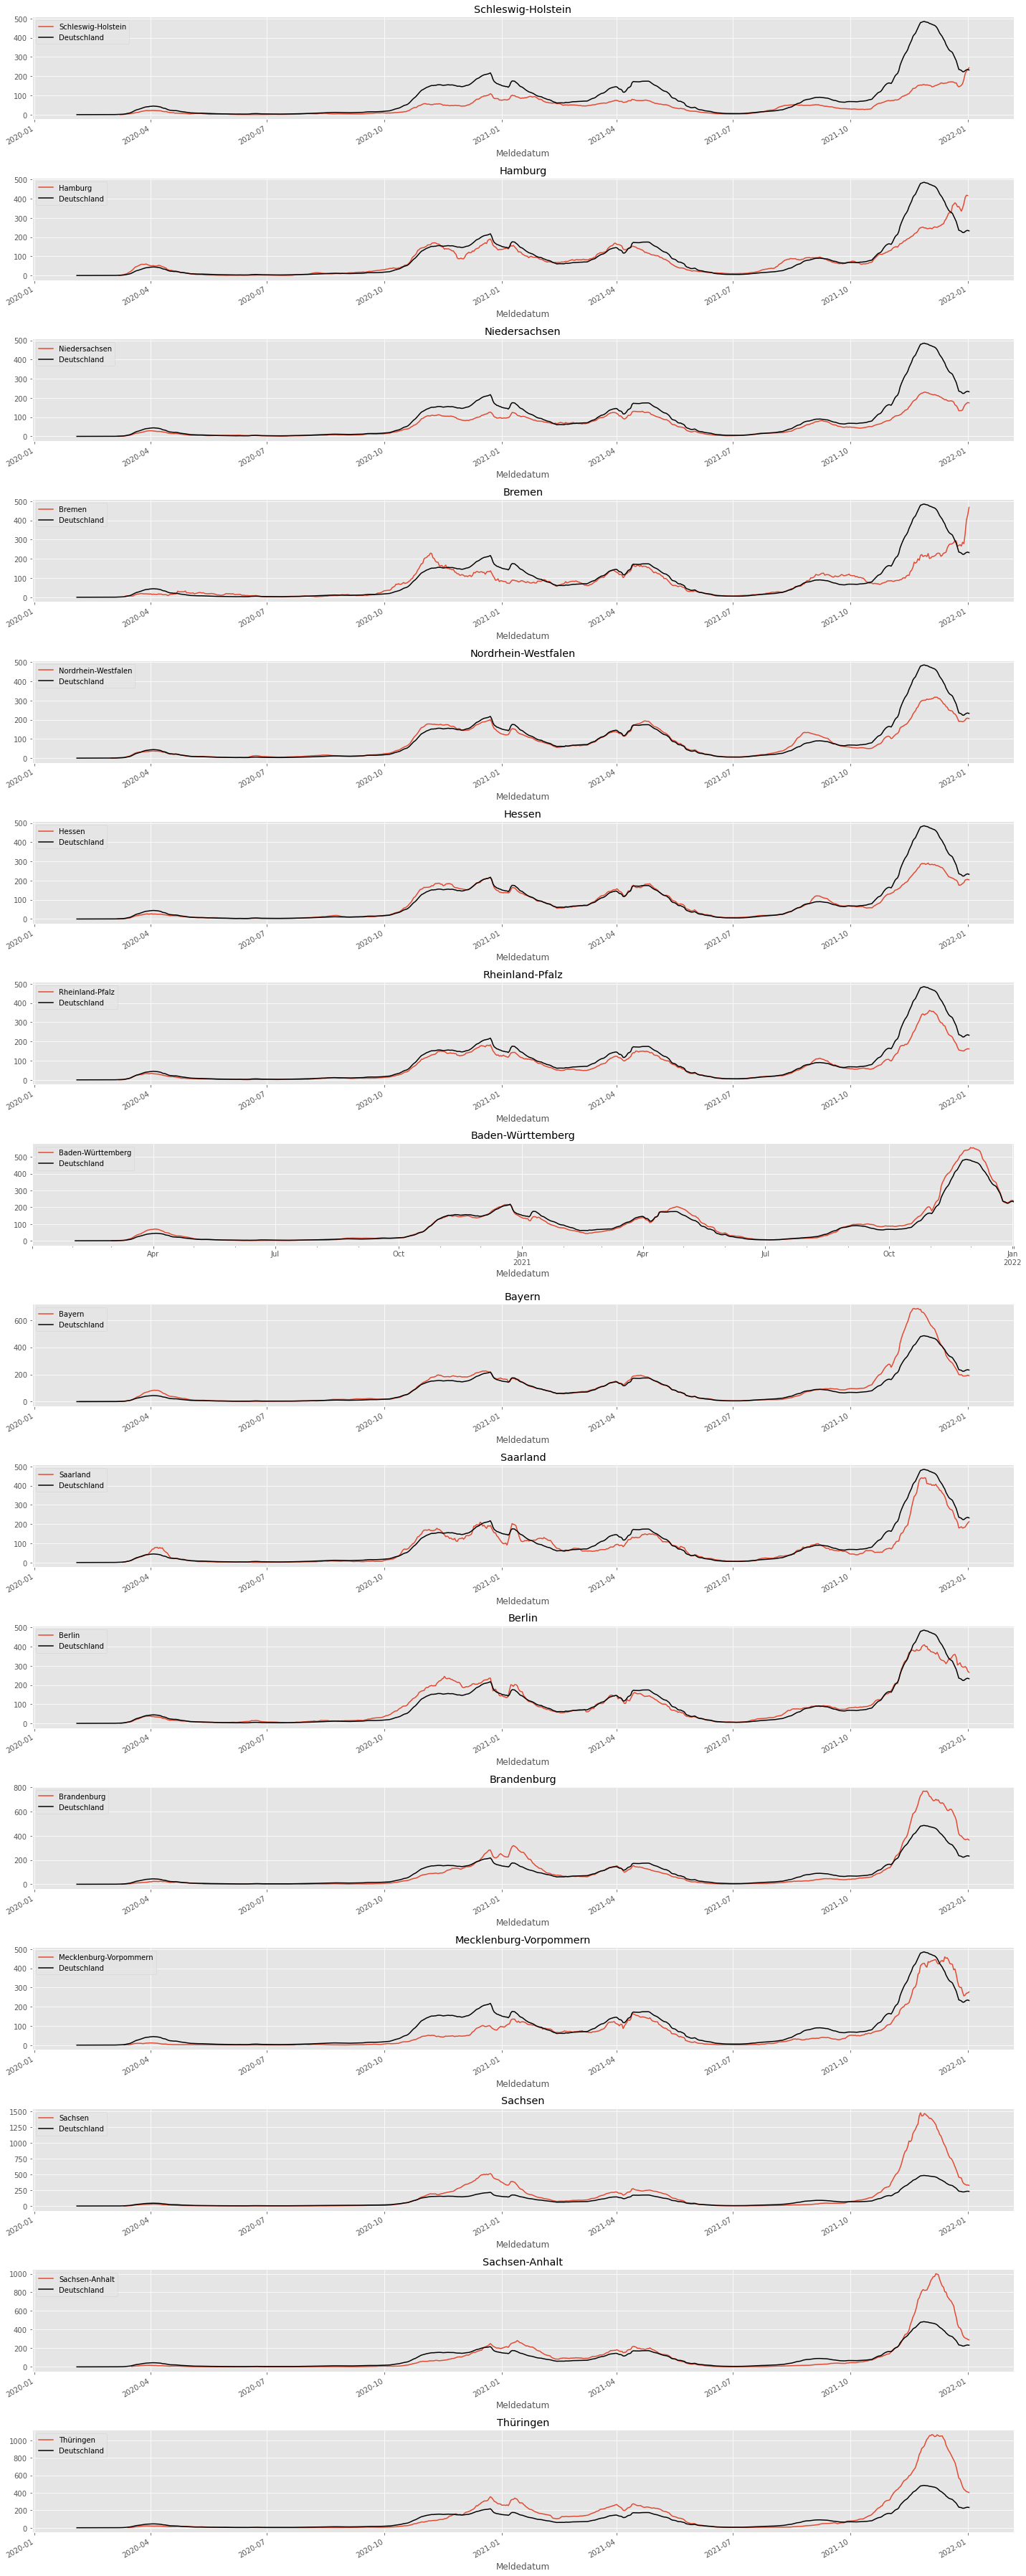

In [14]:
#laender = list(df['Bundesland'].unique())[:-3]
laender = list(df['Bundesland'].unique())
fig, ax = plt.subplots(nrows = len(laender), figsize = (20, 50))

for j, i in enumerate(laender):
    mask = df.loc[:, 'Bundesland'] == i
    df_plot = sevendayavg(df.loc[mask, :].groupby('Meldedatum')[['AnzahlFall', 'AnzahlTodesfall']].sum(), df_ewbl.loc[i, '2020']/100000)
    df_plot.loc[:, '7day_inzidenz'].plot(ax = ax[j], label = i)
    df_plot = sevendayavg(df.groupby('Meldedatum')[['AnzahlFall', 'AnzahlTodesfall']].sum(), df_ewbl.loc['Deutschland', '2020']/100000)
    df_plot.loc[:, '7day_inzidenz'].plot(ax = ax[j], label = 'Deutschland', c = 'k')
    ax[j].set_title(i)
    ax[j].legend(loc='upper left')
   
plt.tight_layout()  
plt.show()